**Introduction**

This script explores the potential of machine learning (Shallow ANN) models to classify Alzheimer's Disease stages (Cognitively Normal (CN), Mild Cognitive Impairment (MCI), and Dementia) using baseline data from the ADNI dataset. Initially, the focus is on using a limited set of features comprising age, APOE4 genotype, and select baseline volumetric MRI measures (Hippocampus, Entorhinal, MidTemp, Ventricles, Fusiform, WholeBrain) to build and evaluate models. This initial experiment aims to understand the inherent predictive power of these specific structural biomarkers and genetic factors. Subsequently, the script investigates the impact of incorporating clinical assessment scores, specifically the Mini-Mental State Examination (MMSE) and Clinical Dementia Rating Sum of Boxes (CDRSB), into the feature set. By comparing model performance and utilizing interpretability techniques like SHAP (SHapley Additive exPlanations) values for both feature sets, the experiment seeks to identify the most influential factors driving the classification and assess the contribution of clinical scores versus the selected neuroimaging and genetic markers in predicting AD progression stages.

In [1]:
#Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTEENN, SMOTETomek


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [3]:
df = pd.read_csv("cleaned_ADNI_baseline_data.csv")

In [4]:
df.head()

,PTID,AGE,APOE4,DX,MMSE,CDRSB,Hippocampus_bl_ICV,Entorhinal_bl_ICV,MidTemp_bl_ICV,Ventricles_bl_ICV,Fusiform_bl_ICV,WholeBrain_bl_ICV
0,011_S_0002,74.3,0.0,CN,28.0,0.0,0.004200,0.002105,0.014076,0.059573,0.008343,0.619623
1,011_S_0003,81.3,1.0,Dementia,20.0,4.5,0.002769,0.000932,0.009591,0.044046,0.008073,0.588242
2,022_S_0004,67.5,0.0,MCI,27.0,1.0,0.004090,0.002372,0.011679,0.023582,0.011335,0.687717
3,011_S_0005,73.7,0.0,CN,29.0,0.0,0.004312,0.002702,0.013173,0.020760,0.015108,0.680552
4,100_S_0006,80.4,0.0,MCI,25.0,0.5,0.003599,0.001532,0.011981,0.026804,0.012090,0.624237


In [5]:
df.columns

Index(['PTID', 'AGE', 'APOE4', 'DX', 'MMSE', 'CDRSB', 'Hippocampus_bl_ICV',
       'Entorhinal_bl_ICV', 'MidTemp_bl_ICV', 'Ventricles_bl_ICV',
       'Fusiform_bl_ICV', 'WholeBrain_bl_ICV'],
      dtype='object')

**Model1** To examine the model performs in real likfe clinical settings we will exclude clinical scores and apply the MRI features and APOE4 genotype. subsequently we will add clinical scores to observe theirinfluence on performance of the model.

In [6]:
# Drop MMSE and CDRSB columns from the dataframe
df = df.drop(columns=['MMSE', 'CDRSB'])
df.shape

(1933, 10)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1933 entries, 0 to 1932
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   PTID                1933 non-null   object 
 1   AGE                 1933 non-null   float64
 2   APOE4               1933 non-null   float64
 3   DX                  1933 non-null   object 
 4   Hippocampus_bl_ICV  1933 non-null   float64
 5   Entorhinal_bl_ICV   1933 non-null   float64
 6   MidTemp_bl_ICV      1933 non-null   float64
 7   Ventricles_bl_ICV   1933 non-null   float64
 8   Fusiform_bl_ICV     1933 non-null   float64
 9   WholeBrain_bl_ICV   1933 non-null   float64
dtypes: float64(8), object(2)
memory usage: 151.1+ KB


In [8]:
print(df.columns)

Index(['PTID', 'AGE', 'APOE4', 'DX', 'Hippocampus_bl_ICV', 'Entorhinal_bl_ICV',
       'MidTemp_bl_ICV', 'Ventricles_bl_ICV', 'Fusiform_bl_ICV',
       'WholeBrain_bl_ICV'],
      dtype='object')


In [9]:
df.head()

,PTID,AGE,APOE4,DX,Hippocampus_bl_ICV,Entorhinal_bl_ICV,MidTemp_bl_ICV,Ventricles_bl_ICV,Fusiform_bl_ICV,WholeBrain_bl_ICV
0,011_S_0002,74.3,0.0,CN,0.004200,0.002105,0.014076,0.059573,0.008343,0.619623
1,011_S_0003,81.3,1.0,Dementia,0.002769,0.000932,0.009591,0.044046,0.008073,0.588242
2,022_S_0004,67.5,0.0,MCI,0.004090,0.002372,0.011679,0.023582,0.011335,0.687717
3,011_S_0005,73.7,0.0,CN,0.004312,0.002702,0.013173,0.020760,0.015108,0.680552
4,100_S_0006,80.4,0.0,MCI,0.003599,0.001532,0.011981,0.026804,0.012090,0.624237


In [10]:
# Select features
features = ['AGE', 'APOE4', 'Hippocampus_bl_ICV', 'Entorhinal_bl_ICV', 'MidTemp_bl_ICV',"Ventricles_bl_ICV","Fusiform_bl_ICV", "WholeBrain_bl_ICV"]
X = df[features]
y = df['DX']

In [11]:
X.head()

,AGE,APOE4,Hippocampus_bl_ICV,Entorhinal_bl_ICV,MidTemp_bl_ICV,Ventricles_bl_ICV,Fusiform_bl_ICV,WholeBrain_bl_ICV
0,74.3,0.0,0.004200,0.002105,0.014076,0.059573,0.008343,0.619623
1,81.3,1.0,0.002769,0.000932,0.009591,0.044046,0.008073,0.588242
2,67.5,0.0,0.004090,0.002372,0.011679,0.023582,0.011335,0.687717
3,73.7,0.0,0.004312,0.002702,0.013173,0.020760,0.015108,0.680552
4,80.4,0.0,0.003599,0.001532,0.011981,0.026804,0.012090,0.624237


In [12]:
# Encode DX target
label_encoder = LabelEncoder()
df['DX'] = label_encoder.fit_transform(df['DX'])

In [13]:
# Encode the DX column
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [14]:
label_mapping = {'CN': 0, 'MCI': 1, 'Dementia': 2}
y_encoded = y.map(label_mapping).values

In [15]:
# Split dataset into train, test, Validation set
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=42
)


In [16]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

In [17]:
from collections import Counter

In [18]:
# Observe the class imbalance befire abd After SMOTE

# Before SMOTE
print("Class distribution before SMOTE:", Counter(y_train))

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# After SMOTE
print("Class distribution after SMOTE:", Counter(y_train_resampled))

Class distribution before SMOTE: Counter({np.int64(1): 556, np.int64(0): 487, np.int64(2): 193})
Class distribution after SMOTE: Counter({np.int64(1): 556, np.int64(0): 556, np.int64(2): 556})


In [19]:
input_dim = X_train_resampled.shape[1]

model = Sequential([
    Dense(32, activation='relu', input_shape=(input_dim,)),
    Dense(16, activation='relu'),
    Dense(3, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [20]:
history = model.fit(
    X_train_resampled, y_train_resampled, # Use the correct variable names from the SMOTE step
    validation_data=(X_val_scaled, y_val),
    epochs=50,
    batch_size=16,
    verbose=1  # Set to 0 if you prefer silent training
)

Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4105 - loss: 1.1479 - val_accuracy: 0.5065 - val_loss: 0.9479
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5830 - loss: 0.8511 - val_accuracy: 0.5548 - val_loss: 0.8879
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6194 - loss: 0.7948 - val_accuracy: 0.5645 - val_loss: 0.8740
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6336 - loss: 0.7804 - val_accuracy: 0.5484 - val_loss: 0.8667
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6429 - loss: 0.7608 - val_accuracy: 0.5452 - val_loss: 0.8618
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6644 - loss: 0.7382 - val_accuracy: 0.5258 - val_loss: 0.8614
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6741 - loss: 0.7301 - val_accuracy: 0.5226 - val_loss: 0.8712
Epoch 8/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6622 - loss: 0.7431 - val_accuracy: 0.

With a very poor result of around 50%

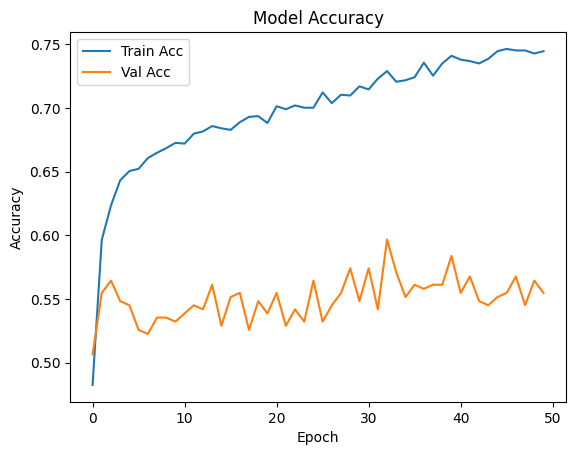

In [21]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Initialize the model with multinomial setting for softmax
log_reg = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=1000,
    random_state=42
)

# Fit on the SMOTE-resampled training set
log_reg.fit(X_train_resampled, y_train_resampled)

# Predict on the validation set
y_val_pred_lr = log_reg.predict(X_val_scaled)

# Evaluate
print("Logistic Regression Accuracy:", accuracy_score(y_val, y_val_pred_lr))
print("\nClassification Report:\n", classification_report(y_val, y_val_pred_lr, target_names=['CN', 'MCI', 'Dementia']))


Logistic Regression Accuracy: 0.5838709677419355

Classification Report:
               precision    recall  f1-score   support

          CN       0.66      0.68      0.67       122
         MCI       0.59      0.43      0.50       139
    Dementia       0.46      0.78      0.58        49

    accuracy                           0.58       310
   macro avg       0.57      0.63      0.58       310
weighted avg       0.60      0.58      0.58       310



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [23]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(X_val_scaled, y_val) # Corrected variable name
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5693 - loss: 0.8681 
Validation Accuracy: 55.48%



🔹 SHAP Summary for class: CN


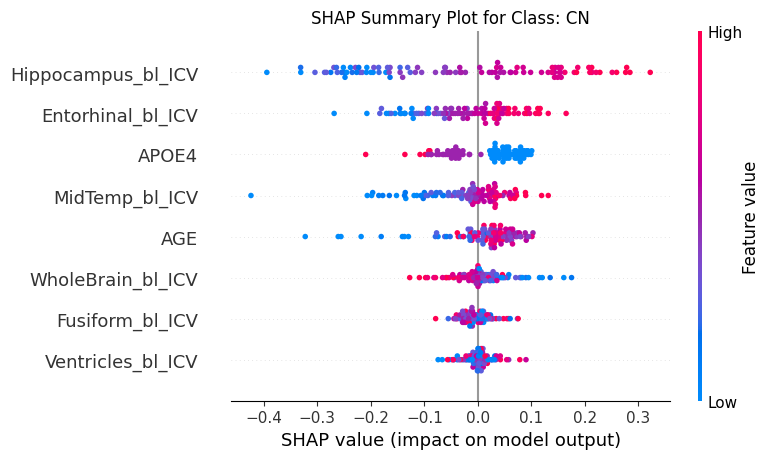


🔹 SHAP Summary for class: Dementia


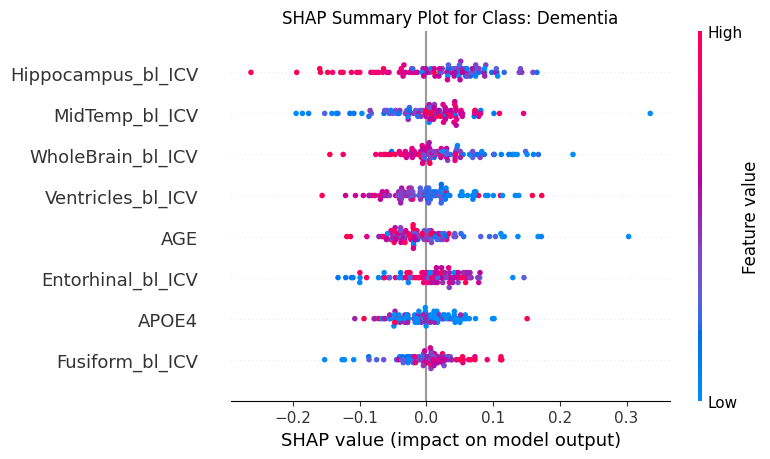


🔹 SHAP Summary for class: MCI


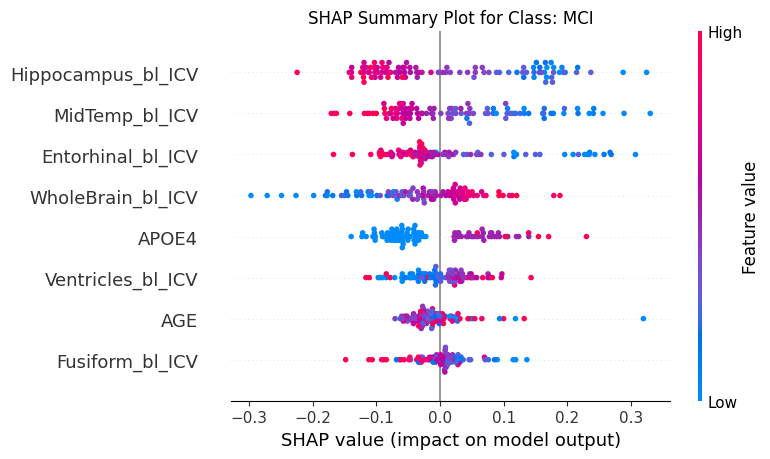

In [24]:
import shap
import pandas as pd
import matplotlib.pyplot as plt

#  Create a DataFrame with feature names
X_sample = X_test_scaled[:100]
X_sample_df = pd.DataFrame(X_sample, columns=features)

# Create SHAP explainer for Keras model
explainer = shap.Explainer(model, X_train_scaled)

# Compute SHAP values
shap_values = explainer(X_sample_df)

# Get actual class names from label encoder
class_names = le.classes_

#  Plot SHAP summary for each class
for i, class_name in enumerate(class_names):
    print(f"\n🔹 SHAP Summary for class: {class_name}")
    # Access the SHAP values for the specific class
    shap.summary_plot(shap_values[:, :, i], X_sample_df, feature_names=features, show=False) # Updated line: Accessing shap_values for the current class
    plt.title(f"SHAP Summary Plot for Class: {class_name}")
    plt.tight_layout()
    plt.show()

**Results:** The models performed poorly with only selected MRI feartures and Age and APOE4. The performance were similar in both shallow ANN and Logistic regression. This might be indicative of the predictive power of the MRI features and the genotype alone.

**Next steps:**Additional features i.e MMSE,CDRSB clinical scores were added, though there is a concern about the validity of adding the clinical scores if they do not inherently leak information to the model.

**Adding Clinical Scores:** MMSE, CDRSB

In [25]:
df = pd.read_csv("cleaned_ADNI_baseline_data.csv")

In [26]:
features_to_use = [
    'AGE', 'APOE4', 'MMSE', 'CDRSB',
    'Hippocampus_bl_ICV', 'Entorhinal_bl_ICV', 'MidTemp_bl_ICV',
    'Ventricles_bl_ICV', 'Fusiform_bl_ICV', 'WholeBrain_bl_ICV'
]


In [27]:
X = df[features_to_use]
y = df['DX']

In [28]:
# Encode the DX column
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [29]:
print(le.classes_)

['CN' 'Dementia' 'MCI']


In [30]:
label_mapping = {'CN': 0, 'MCI': 1, 'Dementia': 2}
y_encoded = y.map(label_mapping).values

In [31]:
# Split dataset into train, test, Validation set
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=42
)

In [32]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

In [33]:
# Observe the class imbalance befire abd After SMOTE

# Before SMOTE
print("Class distribution before SMOTE:", Counter(y_train))

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# After SMOTE
print("Class distribution after SMOTE:", Counter(y_train_resampled))

Class distribution before SMOTE: Counter({np.int64(1): 556, np.int64(0): 487, np.int64(2): 193})
Class distribution after SMOTE: Counter({np.int64(1): 556, np.int64(0): 556, np.int64(2): 556})


In [37]:
# Import necessary layers including Dropout
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

input_dim = X_train_resampled.shape[1]

model = Sequential([
    Dense(64, activation='relu', input_shape=(input_dim,)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(3, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.001), # Now Adam is defined
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [38]:
history = model.fit(
    X_train_resampled, y_train_resampled, # Correct variable name to y_train_resampled
    validation_data=(X_val_scaled, y_val), # Correct variable name to y_val
    epochs=100,
    batch_size=32,
    verbose=1
)

Epoch 1/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.3942 - loss: 1.0058 - val_accuracy: 0.5677 - val_loss: 0.9174
Epoch 2/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6918 - loss: 0.7667 - val_accuracy: 0.7290 - val_loss: 0.7349
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7615 - loss: 0.6516 - val_accuracy: 0.7806 - val_loss: 0.5741
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7876 - loss: 0.5146 - val_accuracy: 0.8129 - val_loss: 0.4739
Epoch 5/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8240 - loss: 0.4313 - val_accuracy: 0.8452 - val_loss: 0.3843
Epoch 6/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8315 - loss: 0.4245 - val_accuracy: 0.8387 - val_loss: 0.3794
Epoch 7/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8651 - loss: 0.3456 - val_accuracy: 0.8516 - val_loss: 0.3315
Epoch 8/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8469 - loss: 0.3538 - val_accuracy: 0.8548 - v

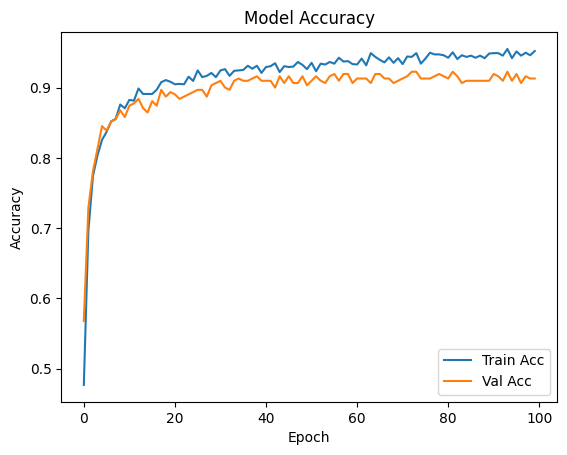

In [39]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


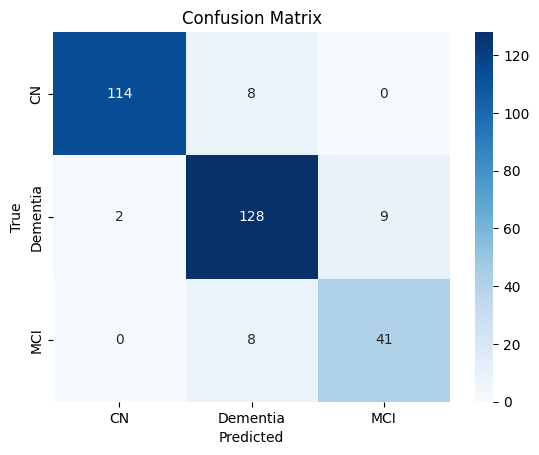

              precision    recall  f1-score   support

          CN       0.98      0.93      0.96       122
    Dementia       0.89      0.92      0.90       139
         MCI       0.82      0.84      0.83        49

    accuracy                           0.91       310
   macro avg       0.90      0.90      0.90       310
weighted avg       0.91      0.91      0.91       310



In [40]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt # Import matplotlib here as well for plt

# Predict on validation set
y_pred = model.predict(X_val_scaled)
y_pred_classes = y_pred.argmax(axis=1)

# Confusion Matrix

cm = confusion_matrix(y_val, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Classification Report

print(classification_report(y_val, y_pred_classes, target_names=label_encoder.classes_))


🔹 SHAP Summary for class: CN


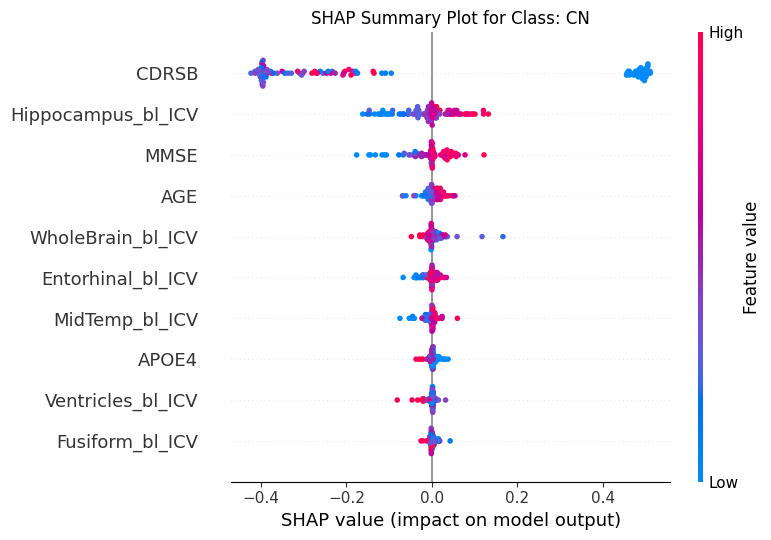


🔹 SHAP Summary for class: Dementia


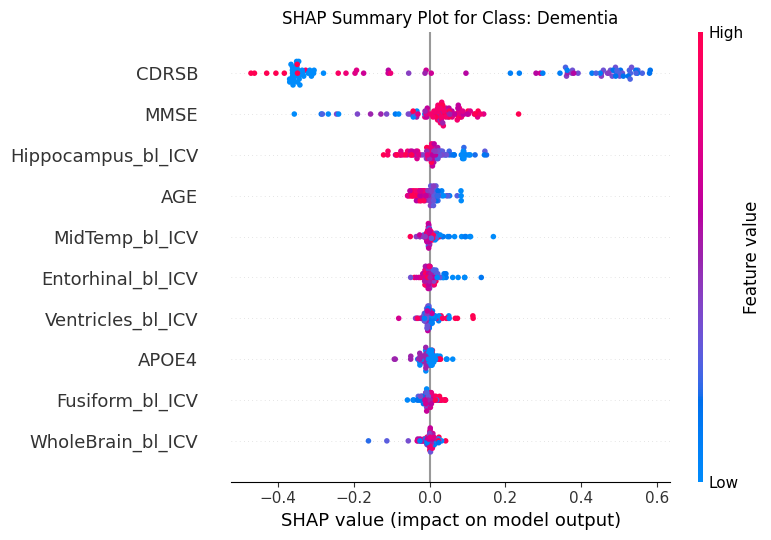


🔹 SHAP Summary for class: MCI


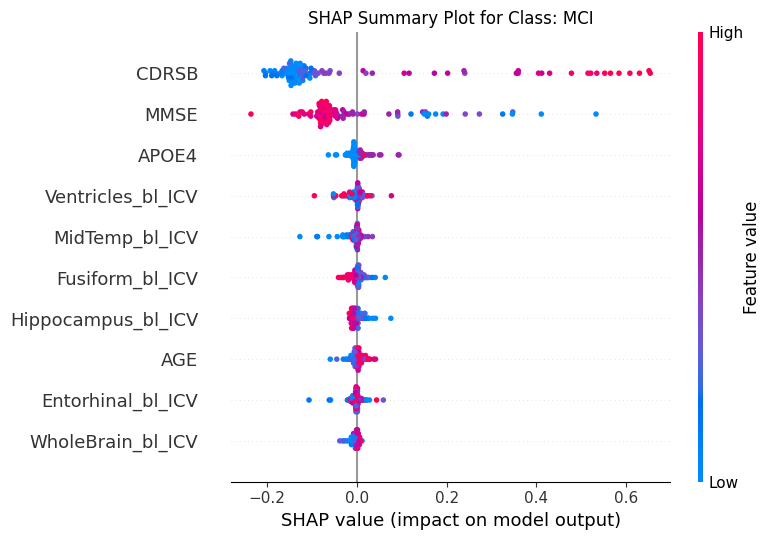

In [42]:
#  Create a DataFrame with feature names
X_sample = X_test_scaled[:100]

# Define the features used in the second model
features_for_shap = [
    'AGE', 'APOE4', 'MMSE', 'CDRSB',
    'Hippocampus_bl_ICV', 'Entorhinal_bl_ICV', 'MidTemp_bl_ICV',
    'Ventricles_bl_ICV', 'Fusiform_bl_ICV', 'WholeBrain_bl_ICV'
]

# Use the updated feature list when creating the DataFrame
X_sample_df = pd.DataFrame(X_sample, columns=features_for_shap)

# Create SHAP explainer for Keras model
# Note: It's often better to use a subset of the training data for the background distribution,
# but using X_train_scaled is acceptable for basic SHAP analysis.
explainer = shap.Explainer(model, X_train_scaled)

# Compute SHAP values
shap_values = explainer(X_sample_df)

# Get actual class names from label encoder
class_names = le.classes_

#  Plot SHAP summary for each class
for i, class_name in enumerate(class_names):
    print(f"\n🔹 SHAP Summary for class: {class_name}")
    # Access the SHAP values for the specific class and use the updated feature list for plotting
    shap.summary_plot(shap_values[:, :, i], X_sample_df, feature_names=features_for_shap, show=False)
    plt.title(f"SHAP Summary Plot for Class: {class_name}")
    plt.tight_layout()
    plt.show()

**Observations and Insights**

Both shallow and moderately deep ANN models achieved ~90–91% accuracy, but their performance dropped significantly without clinical scores (MMSE, CDRSB). This trend was also observed in simpler models like logistic regression, indicating a strong model reliance on cognitive assessments.

SHAP Analysis Summary:
Cognitively Normal (CN):

High MMSE and low CDRSB strongly contribute to CN predictions.

Larger hippocampus and whole brain volume support CN classification.

APOE4-negative status and younger age increase likelihood of CN.

Mild Cognitive Impairment (MCI):

Higher CDRSB and lower MMSE push predictions toward MCI.

MRI contributions are subtler; may suggest a need for more sensitive MRI-derived features.

Dementia:

High CDRSB and low MMSE are strong dementia indicators.

Reduced hippocampal volume and increased ventricle size play a notable role.

SHAP indicates low MRI feature contribution when cognitive scores are absent.

**Next Steps**

1. Investigate and add other non invasive biomarkers, e.g blood-based biomarkers, Demographic Information, other polygenic risk scores.


2. Improve Feature Engineering on MRI Data
Create region-based ratios (e.g., hippocampus/ventricles, cortical/subcortical volume ratios) to better reflect neurodegeneration.

3. Compute asymmetry scores between left/right brain regions.
Normalize MRI features by age or ICV, or compute z-scores for volumetric deviations.

4. Evaluate Model Without Cognitive Scores
Re-train and evaluate models excluding MMSE and CDRSB, using improved MRI features to test early prediction potential.

